In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.features import geometry_mask
from matplotlib.ticker import MaxNLocator

In [2]:
latitudes = np.array([-22.75, -22.75, -22.85, -22.85, -22.85, -22.85, -22.85, -22.85, -22.95, -22.95, -22.95, -22.95, -22.95, -22.95, -23.05, -23.05, -23.05, -23.05, -23.05, -23.05, -23.15, -23.15, -23.15, -23.15, -23.25, -23.25, -23.25, -23.25])

longitudes = np.array([-44.25, -44.35, -44.15, -44.25, -44.35, -44.45, -44.55, -44.65, -44.15, -44.25, -44.35, -44.45, -44.55, -44.65, -44.15, -44.25, -44.35, -44.45, -44.55, -44.65, -44.05, -44.15, -44.25, -44.35, -44.05, -44.15, -44.25, -44.35])

ocorrencias = np.array([30,30,30,31,32,33,33,33,29,28,31,32,33,34,27,30,30,32,33,34,27,28,30,30,27,28,29,30])

In [3]:
# Criar uma grade de coordenadas
grid_lon, grid_lat = np.meshgrid(np.linspace(min(longitudes), max(longitudes), 100),
                                 np.linspace(min(latitudes), max(latitudes), 100))

# Interpolação dos valores na grade
grid_values = griddata((longitudes, latitudes), ocorrencias, (grid_lon, grid_lat), method='cubic')

# shapefile Angra
gdf = gpd.read_file("C:\IC\Mapa\Estados_utm23s.shp")


In [4]:
# Certificar-se de que as coordenadas estão no mesmo sistema de referência
if gdf.crs != "EPSG:4674":
    gdf = gdf.to_crs("EPSG:4674")

# Obter os limites do shapefile
bounds = gdf.total_bounds  # minx, miny, maxx, maxy

# Criar uma grade de coordenadas que corresponda aos limites do shapefile
grid_lon, grid_lat = np.meshgrid(np.linspace(bounds[0], bounds[2], 500),
                                 np.linspace(bounds[1], bounds[3], 500))

# Interpolação dos valores na nova grade
grid_values = griddata((longitudes, latitudes), ocorrencias, (grid_lon, grid_lat), method='cubic')

# Criar uma máscara a partir dos limites do município
transform = rasterio.transform.from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], grid_lon.shape[1], grid_lat.shape[0])
municipio_mask = geometry_mask([geom for geom in gdf.geometry], transform=transform, invert=True, out_shape=grid_lat.shape)

# Reverse the order of elements along axis 0 (up/down).
municipio_mask = np.flipud(municipio_mask)

# Aplicar a máscara nos valores interpolados
masked_grid_values = np.ma.array(grid_values, mask=~municipio_mask)


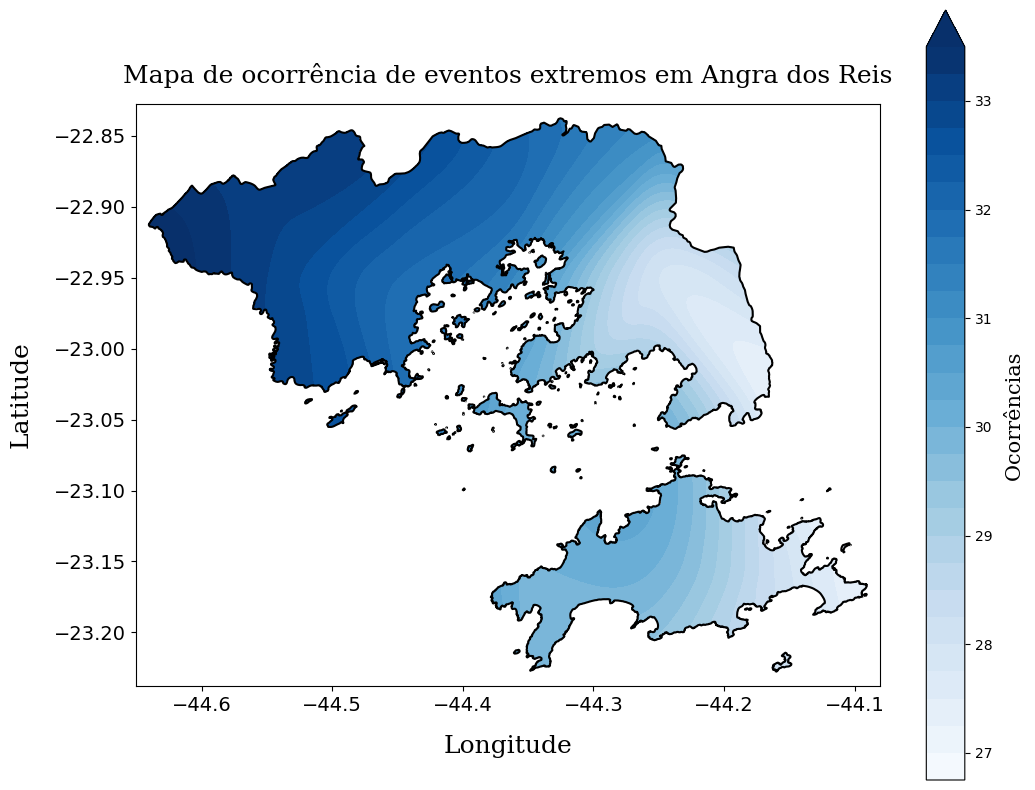

In [5]:
# Configurar a colormap de branco a azul
cmap = plt.cm.Blues
cmap.set_bad(color='white')

# Plotar as isoietas
plt.figure(figsize=(12, 10))

# Crianção do mapa de contorno
contour = plt.contourf(grid_lon, grid_lat, masked_grid_values, levels=30, cmap=cmap, extend='max')

# Adicionar a barra de cores
cbar = plt.colorbar(contour, label='Ocorrências')

# Ajustar o tamanho, distância e fonte do label da colorbar
cbar.set_label('Ocorrências ', fontsize=15, labelpad=10, fontfamily='serif')  # Ajusta o texto do rótulo
cbar.ax.yaxis.label.set_size(15)  # Tamanho da fonte do rótulo
cbar.ax.yaxis.label.set_fontfamily('serif')  # Tipo de fonte do rótulo


# Configurar os rótulos da colorbar para serem inteiros
cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Ajuste os valores e o intervalo como necessário
cbar.set_ticks(np.arange(27, 34))  

# Plotar os limites do município
gdf.boundary.plot(ax=plt.gca(), edgecolor='k')

# Configurar os rótulos e o título do gráfico
plt.xlabel('Longitude', fontsize=18, labelpad= 15, fontfamily = 'serif')
plt.ylabel('Latitude', fontsize=18, labelpad= 15, fontfamily = 'serif')

# Definindo o título
plt.title('Mapa de ocorrência de eventos extremos em Angra dos Reis', fontsize=18, pad=15, fontfamily = 'serif')

# Definindo ajustes nos eixos x e y
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Ajustar os limites do gráfico para diminuir o zoom
plt.xlim(bounds[0] - 0.01, bounds[2] + 0.01)
plt.ylim(bounds[1] - 0.01, bounds[3] + 0.01)

plt.show()